# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.head(10)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3,1,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,-1,2,2,5.0,1,5,1,5,4,3,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,-1,1,1,3.0,3,3,4,1,3,2,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,-1,3,1,3.0,4,4,2,4,2,2,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,-1,3,2,4.0,2,4,2,3,5,4,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [4]:
original_missing = azdias.isnull().sum()
original_missing.sum()

4896838

In [5]:
feat_info

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [6]:
# Identify missing or unknown data values and convert them to NaNs.
feat_info_clean = feat_info.copy()
feat_info_clean.missing_or_unknown = feat_info.missing_or_unknown.str.strip('[').str.strip(']')
feat_info_clean.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"-1,0"
1,ALTERSKATEGORIE_GROB,person,ordinal,"-1,0,9"
2,ANREDE_KZ,person,categorical,"-1,0"
3,CJT_GESAMTTYP,person,categorical,0
4,FINANZ_MINIMALIST,person,ordinal,-1


In [7]:
feat_info_clean[['first_null', 'second_null', 'third_null']] = feat_info_clean.missing_or_unknown.str.split(',', expand=True)
feat_info_clean.head()

,attribute,information_level,type,missing_or_unknown,first_null,second_null,third_null
0,AGER_TYP,person,categorical,"-1,0",-1,0,None
1,ALTERSKATEGORIE_GROB,person,ordinal,"-1,0,9",-1,0,9
2,ANREDE_KZ,person,categorical,"-1,0",-1,0,None
3,CJT_GESAMTTYP,person,categorical,0,0,None,None
4,FINANZ_MINIMALIST,person,ordinal,-1,-1,None,None


In [8]:
## Create dataframe to assist with replacing 
replace_df = feat_info_clean[['attribute', 'first_null', 'second_null', 'third_null']]
# Transpose for easier comparisons
replace_df = replace_df.set_index('attribute').transpose()
replace_df.head()

attribute,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
first_null,-1,-1,-1,0,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
second_null,0,0,0,None,None,None,None,None,None,None,...,None,None,None,None,0,None,None,9,0,9
third_null,None,9,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [9]:
for col in replace_df.columns:
    try:
        replace_df[col] = replace_df[col].astype(float)
    except:
        continue
        

In [10]:
(replace_df.dtypes == 'float64').sum()


72

In [11]:
(azdias.dtypes == 'float64').sum()


49

In [12]:
replace_df.transpose()[replace_df.dtypes != float]

,first_null,second_null,third_null
attribute,,,
GFK_URLAUBERTYP,,None,None
GREEN_AVANTGARDE,,None,None
ANZ_PERSONEN,,None,None
ANZ_TITEL,,None,None
ANZ_HH_TITEL,,None,None
KONSUMNAEHE,,None,None
CAMEO_DEUG_2015,-1,X,None
CAMEO_DEU_2015,XX,None,None
CAMEO_INTL_2015,-1,XX,None


In [13]:
replace_dict = replace_df.to_dict(orient='list')

In [56]:
azdias_clean = azdias.copy()

In [57]:
for col in azdias_clean.columns:
    try:
        azdias_clean[col] = azdias_clean[col].astype(float)
    except:
        continue

In [58]:
azdias_clean.replace(replace_dict, np.nan, inplace=True)

In [59]:
replaced = azdias_clean.isnull().sum()
replaced.sum()

8373929

In [60]:
(replaced - original_missing).sum()

3477091

#### Discussion 1.1.1: Convert Missing Value Codes to NaNs

-  I converted as many values to floats as possible to ensure thant numerical data was being captured. 72 columns were converted to float. Then, I replaced Missing Value values to NaNs value. 
- There are now 8,373,929 values that are missing. That's a lot of missing values but still only a bit over 10%. Conducting this replacement found an additional 3,477,091 missing values.

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [61]:
replaced


AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [62]:
replaced.describe()

count        85.000000
mean      98516.811765
std      146604.203317
min           0.000000
25%           0.000000
50%       93148.000000
75%      116515.000000
max      889061.000000
dtype: float64

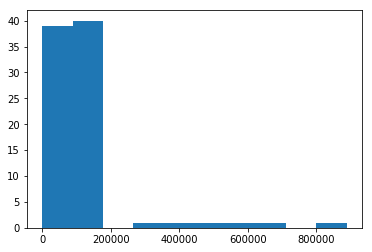

In [63]:
replaced.hist(grid=False);

In [64]:
high_missing = replaced[replaced > 200000].index
azdias_clean.drop(high_missing, axis=1, inplace=True)
azdias_clean.shape

(891221, 79)

In [65]:
high_missing

Index(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP',
       'KBA05_BAUMAX'],
      dtype='object')

#### Discussion 1.1.2: Assess Missing Data in Each Column

- The maximum number of values missing from a column is 889,061. Given that are 891,221 rows of data, this is over 90% missing data
- The six columns that were dropped were AGER_TYP, GEBURTSJAHR, TITEL_KZ, ALTER_HH, KK_KUNDENTYP, and  KBA05_BAUMAX.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [66]:
# How much data is missing in each row of the dataset?
missing_rows = azdias_clean.isnull()
missing_rows.sum(axis=1)


0         43
1          0
2          0
3          7
4          0
5          0
6          0
7          0
8          0
9          0
10         0
11        47
12         6
13         8
14        47
15         8
16         6
17        47
18         3
19         0
20        10
21         0
22         0
23         8
24        47
25         5
26        19
27         0
28         0
29         2
          ..
891191     0
891192     0
891193     0
891194     0
891195     0
891196     0
891197     0
891198     0
891199     0
891200     0
891201     0
891202     0
891203    14
891204     0
891205     0
891206     0
891207     0
891208     3
891209     0
891210     0
891211     0
891212     0
891213     0
891214     0
891215     0
891216     3
891217     4
891218     5
891219     0
891220     0
Length: 891221, dtype: int64

In [67]:
missing_row_totals = missing_rows.sum(axis=1)
missing_row_totals.describe()

count    891221.000000
mean          5.649894
std          13.234687
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max          49.000000
dtype: float64

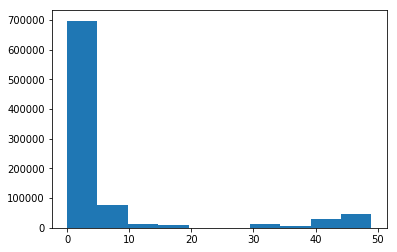

In [68]:
missing_row_totals.hist(grid=False);

In [69]:
azdias_clean['complete'] = azdias_clean.isnull().sum(axis=1) == 0
azdias_clean.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,complete
0,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,...,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,True
2,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,...,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,True
3,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,6.0,...,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,False
4,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,...,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,True


In [70]:
azdias_clean.complete.sum()

623209

In [71]:
azdias_clean.complete.sum()/azdias_clean.shape[0]

0.69927548834688591

In [72]:
low_missing_columns = replaced[replaced < 5].index 
print('Columns with low missing values:', len(low_missing_columns))

Columns with low missing values: 24


In [73]:
sample_columns = np.random.choice(low_missing_columns, 5)
sample_columns

array(['SEMIO_KRIT', 'FINANZTYP', 'SEMIO_RAT', 'FINANZ_ANLEGER',
       'SEMIO_KRIT'], dtype=object)

In [74]:
sample_columns_list = list(sample_columns)
sample_columns_list.append('complete')
azdias_clean[sample_columns_list].head()

,SEMIO_KRIT,FINANZTYP,SEMIO_RAT,FINANZ_ANLEGER,SEMIO_KRIT,complete
0,7.0,4.0,4.0,5.0,7.0,False
1,4.0,1.0,6.0,5.0,4.0,True
2,7.0,1.0,4.0,2.0,7.0,True
3,4.0,6.0,3.0,2.0,4.0,False
4,3.0,5.0,2.0,1.0,3.0,True


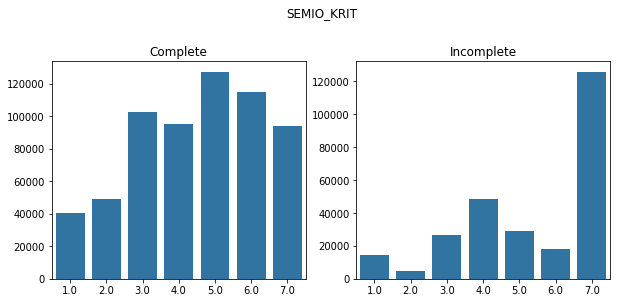

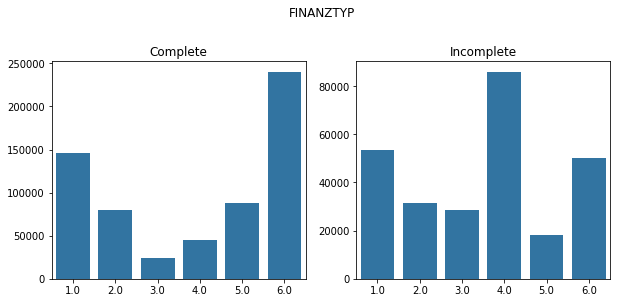

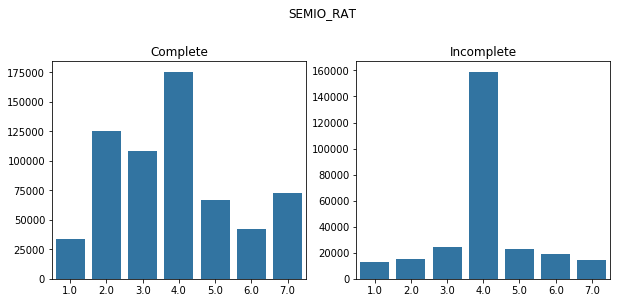

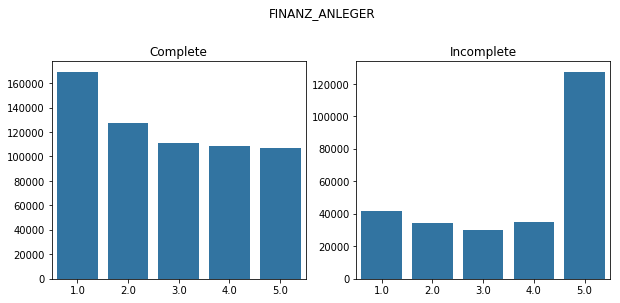

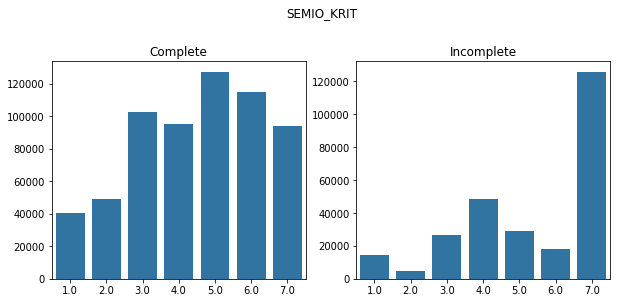

In [75]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
def count_complete_Incomplete(data, selected_col):
    complete = azdias_clean[azdias_clean['complete']]
    incomplete = azdias_clean[~azdias_clean['complete']]
    selected_color = sns.color_palette()[0]
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    sns.countplot(x=selected_col, data=complete, color=selected_color)
    plt.title('Complete')
    plt.xlabel('')
    plt.ylabel('')
    plt.subplot(1, 2, 2)
    sns.countplot(x=selected_col, data=incomplete, color=selected_color)
    plt.title('Incomplete')
    plt.xlabel('')
    plt.ylabel('')
    plt.suptitle(selected_col, y=1.07)
    plt.show();
for col in sample_columns:
    count_complete_Incomplete(azdias_clean, col)


In [76]:
azdias_clean.dropna(inplace=True)
azdias_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 623209 entries, 1 to 891220
Data columns (total 80 columns):
ALTERSKATEGORIE_GROB     623209 non-null float64
ANREDE_KZ                623209 non-null float64
CJT_GESAMTTYP            623209 non-null float64
FINANZ_MINIMALIST        623209 non-null float64
FINANZ_SPARER            623209 non-null float64
FINANZ_VORSORGER         623209 non-null float64
FINANZ_ANLEGER           623209 non-null float64
FINANZ_UNAUFFAELLIGER    623209 non-null float64
FINANZ_HAUSBAUER         623209 non-null float64
FINANZTYP                623209 non-null float64
GFK_URLAUBERTYP          623209 non-null float64
GREEN_AVANTGARDE         623209 non-null float64
HEALTH_TYP               623209 non-null float64
LP_LEBENSPHASE_FEIN      623209 non-null float64
LP_LEBENSPHASE_GROB      623209 non-null float64
LP_FAMILIE_FEIN          623209 non-null float64
LP_FAMILIE_GROB          623209 non-null float64
LP_STATUS_FEIN           623209 non-null float64
LP_STAT

#### Discussion 1.1.3: Assess Missing Data in Each Row

- It appears that some columns never have missing values, as the highest number of missing data per row is 49. I created a column that clearly distinguished which rows had no missing data.

- I droped all rows with missing data. we will still retain almost 70% of the dataset(Which is reasonable).
- The data with lots of missing values are different from data with few or no missing values.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [77]:
# How many features are there of each data type?
feat_info_clean.type.value_counts()

ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [78]:
feat_info_clean = feat_info_clean[~feat_info_clean.attribute.isin(high_missing)]

In [79]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
categorical_columns = feat_info_clean.query('type == "categorical"').attribute
#print('# Categorical features:', len(categorical_columns))

# Find binary columns
binary_columns = []
for col in categorical_columns:
    value_count = azdias_clean[col].value_counts()
    if len(value_count) ==2:
        binary_columns.append(col)
print('Namber of Binary features:', len(binary_columns))
print('Binary features are: {}'.format(binary_columns))
print('Number of Multi-level features:', len(categorical_columns))
print('Multi-level features are: {}'.format(categorical_columns))


Namber of Binary features: 5
Binary features are: ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']
Number of Multi-level features: 18
Multi-level features are: 2            ANREDE_KZ
3        CJT_GESAMTTYP
10           FINANZTYP
12     GFK_URLAUBERTYP
13    GREEN_AVANTGARDE
17     LP_FAMILIE_FEIN
18     LP_FAMILIE_GROB
19      LP_STATUS_FEIN
20      LP_STATUS_GROB
21    NATIONALITAET_KZ
38         SHOPPER_TYP
39             SOHO_KZ
41            VERS_TYP
42            ZABEOTYP
52         GEBAEUDETYP
55         OST_WEST_KZ
57     CAMEO_DEUG_2015
58      CAMEO_DEU_2015
Name: attribute, dtype: object


#### Binary features

In [80]:
for col in binary_columns:
    if azdias_clean[col].dtypes == object:
        print(azdias_clean[col].value_counts())
    

W    490879
O    132330
Name: OST_WEST_KZ, dtype: int64


In [81]:
# Re-encode categorical variable(s) to be kept in the analysis.
recode = {'O': 0, 'W': 1}
azdias_clean.replace({'OST_WEST_KZ': recode}, inplace=True)
# Test
assert(azdias_clean.OST_WEST_KZ.unique().all() in [0, 1])

### Multi-level Features

In [82]:
multi_columns = categorical_columns[~categorical_columns.isin(binary_columns)]
multi_columns

3        CJT_GESAMTTYP
10           FINANZTYP
12     GFK_URLAUBERTYP
17     LP_FAMILIE_FEIN
18     LP_FAMILIE_GROB
19      LP_STATUS_FEIN
20      LP_STATUS_GROB
21    NATIONALITAET_KZ
38         SHOPPER_TYP
42            ZABEOTYP
52         GEBAEUDETYP
57     CAMEO_DEUG_2015
58      CAMEO_DEU_2015
Name: attribute, dtype: object

In [83]:
for col in multi_columns:
    value_counts = azdias_clean[col].value_counts()
    print('\n')
    print(value_counts)
    print('Total:', value_counts.sum())



4.0    160908
3.0    119004
2.0    113203
5.0     79854
6.0     77273
1.0     72967
Name: CJT_GESAMTTYP, dtype: int64
Total: 623209


6.0    240292
1.0    146234
5.0     88119
2.0     79302
4.0     44630
3.0     24632
Name: FINANZTYP, dtype: int64
Total: 623209


12.0    98076
10.0    81624
8.0     69405
11.0    60164
5.0     57326
4.0     51615
3.0     44233
9.0     41272
1.0     39929
7.0     31423
2.0     27430
6.0     20712
Name: GFK_URLAUBERTYP, dtype: int64
Total: 623209


1.0     325104
10.0    108290
2.0      80801
11.0     41248
8.0      16764
7.0      14077
4.0       9174
5.0       9123
9.0       8831
6.0       6211
3.0       3586
Name: LP_FAMILIE_FEIN, dtype: int64
Total: 623209


1.0    325104
5.0    158369
2.0     80801
4.0     37052
3.0     21883
Name: LP_FAMILIE_GROB, dtype: int64
Total: 623209


1.0     175564
9.0      97350
10.0     93471
2.0      81016
3.0      58334
4.0      58008
6.0      23303
5.0      17870
8.0      10742
7.0       7551
Name: LP_STATUS_FEIN, dty

In [84]:
azdias_clean.shape

(623209, 80)

In [85]:
azdias_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 623209 entries, 1 to 891220
Data columns (total 80 columns):
ALTERSKATEGORIE_GROB     623209 non-null float64
ANREDE_KZ                623209 non-null float64
CJT_GESAMTTYP            623209 non-null float64
FINANZ_MINIMALIST        623209 non-null float64
FINANZ_SPARER            623209 non-null float64
FINANZ_VORSORGER         623209 non-null float64
FINANZ_ANLEGER           623209 non-null float64
FINANZ_UNAUFFAELLIGER    623209 non-null float64
FINANZ_HAUSBAUER         623209 non-null float64
FINANZTYP                623209 non-null float64
GFK_URLAUBERTYP          623209 non-null float64
GREEN_AVANTGARDE         623209 non-null float64
HEALTH_TYP               623209 non-null float64
LP_LEBENSPHASE_FEIN      623209 non-null float64
LP_LEBENSPHASE_GROB      623209 non-null float64
LP_FAMILIE_FEIN          623209 non-null float64
LP_FAMILIE_GROB          623209 non-null float64
LP_STATUS_FEIN           623209 non-null float64
LP_STAT

In [86]:
azdias_clean=azdias_clean.drop(['LP_STATUS_FEIN', 'LP_STATUS_GROB', 'CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'FINANZTYP',  
                'SHOPPER_TYP', 'ZABEOTYP', 'LP_FAMILIE_FEIN', 'GEBAEUDETYP'], axis = 1)
azdias_clean.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 623209 entries, 1 to 891220
Data columns (total 71 columns):
ALTERSKATEGORIE_GROB     623209 non-null float64
ANREDE_KZ                623209 non-null float64
CJT_GESAMTTYP            623209 non-null float64
FINANZ_MINIMALIST        623209 non-null float64
FINANZ_SPARER            623209 non-null float64
FINANZ_VORSORGER         623209 non-null float64
FINANZ_ANLEGER           623209 non-null float64
FINANZ_UNAUFFAELLIGER    623209 non-null float64
FINANZ_HAUSBAUER         623209 non-null float64
GFK_URLAUBERTYP          623209 non-null float64
GREEN_AVANTGARDE         623209 non-null float64
HEALTH_TYP               623209 non-null float64
LP_LEBENSPHASE_FEIN      623209 non-null float64
LP_LEBENSPHASE_GROB      623209 non-null float64
LP_FAMILIE_GROB          623209 non-null float64
NATIONALITAET_KZ         623209 non-null float64
PRAEGENDE_JUGENDJAHRE    623209 non-null float64
RETOURTYP_BK_S           623209 non-null float64
SEMIO_S

In [87]:
from sklearn.preprocessing import OneHotEncoder
cat_keep_columns = ['CJT_GESAMTTYP', 'LP_FAMILIE_GROB', 
                    'GFK_URLAUBERTYP', 'NATIONALITAET_KZ']

# Create df for cat and non-cat columns
azdias_cat = azdias_clean[cat_keep_columns]
azdias_non_cat = azdias_clean.drop(cat_keep_columns, axis=1)

# Implement one-hot encoding
enc = OneHotEncoder(handle_unknown='ignore')
azdias_encode_cat = enc.fit_transform(azdias_cat).toarray()

In [88]:
cat_cols = ['CJT_GESAMTTYP_1', 'CJT_GESAMTTYP_2', 'CJT_GESAMTTYP_3', 
            'CJT_GESAMTTYP_4', 'CJT_GESAMTTYP_5', 'CJT_GESAMTTYP_6', 
            'LP_FAMILIE_GROB_1', 'LP_FAMILIE_GROB_2', 'LP_FAMILIE_GROB_3', 
            'LP_FAMILIE_GROB_4', 'LP_FAMILIE_GROB_5', 'GFK_URLAUBERTYP_1', 
            'GFK_URLAUBERTYP_2', 'GFK_URLAUBERTYP_3', 'GFK_URLAUBERTYP_4', 
            'GFK_URLAUBERTYP_5', 'GFK_URLAUBERTYP_6', 'GFK_URLAUBERTYP_7', 
            'GFK_URLAUBERTYP_8', 'GFK_URLAUBERTYP_9', 'GFK_URLAUBERTYP_10', 
            'GFK_URLAUBERTYP_11', 'GFK_URLAUBERTYP_12', 'NATIONALITAET_KZ_1', 
            'NATIONALITAET_KZ_2', 'NATIONALITAET_KZ_3']

In [89]:
azdias_dummies = azdias_non_cat.join(
    pd.DataFrame(azdias_encode_cat, azdias_non_cat.index, columns=cat_cols)
)
azdias_dummies.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,GFK_URLAUBERTYP_6,GFK_URLAUBERTYP_7,GFK_URLAUBERTYP_8,GFK_URLAUBERTYP_9,GFK_URLAUBERTYP_10,GFK_URLAUBERTYP_11,GFK_URLAUBERTYP_12,NATIONALITAET_KZ_1,NATIONALITAET_KZ_2,NATIONALITAET_KZ_3
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6,2.0,2.0,1.0,5.0,1.0,5.0,4.0,3.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [90]:
azdias_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 623209 entries, 1 to 891220
Data columns (total 93 columns):
ALTERSKATEGORIE_GROB     623209 non-null float64
ANREDE_KZ                623209 non-null float64
FINANZ_MINIMALIST        623209 non-null float64
FINANZ_SPARER            623209 non-null float64
FINANZ_VORSORGER         623209 non-null float64
FINANZ_ANLEGER           623209 non-null float64
FINANZ_UNAUFFAELLIGER    623209 non-null float64
FINANZ_HAUSBAUER         623209 non-null float64
GREEN_AVANTGARDE         623209 non-null float64
HEALTH_TYP               623209 non-null float64
LP_LEBENSPHASE_FEIN      623209 non-null float64
LP_LEBENSPHASE_GROB      623209 non-null float64
PRAEGENDE_JUGENDJAHRE    623209 non-null float64
RETOURTYP_BK_S           623209 non-null float64
SEMIO_SOZ                623209 non-null float64
SEMIO_FAM                623209 non-null float64
SEMIO_REL                623209 non-null float64
SEMIO_MAT                623209 non-null float64
SEMIO_V

#### Discussion 1.2.1: Re-Encode Categorical Features

- OST_WEST_KZ was identified as a binary variable that was encoded with strings and so this was converted to a binary variable with [0, 1] as it's classes.
-  I decided to keep variables that seemed likely to capture the same type of data and only kept one of these. They are: CJT_GESAMTTYP and  LP_FAMILIE_GROB. And keep GFK_URLAUBERTYP and  NATIONALITAET_KZ.


#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [91]:
feat_info_clean.query('type == "mixed"')

,attribute,information_level,type,missing_or_unknown,first_null,second_null,third_null
15,LP_LEBENSPHASE_FEIN,person,mixed,0,0,None,None
16,LP_LEBENSPHASE_GROB,person,mixed,0,0,None,None
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"-1,0",-1,0,None
56,WOHNLAGE,building,mixed,-1,-1,None,None
59,CAMEO_INTL_2015,microcell_rr4,mixed,"-1,XX",-1,XX,None
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"-1,0",-1,0,None


In [92]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
# Remove mixed categorical variables
azdias_dummies['DECADE'] = azdias_dummies['PRAEGENDE_JUGENDJAHRE']
azdias_dummies['MOVEMENT'] = azdias_dummies['PRAEGENDE_JUGENDJAHRE']
decade_dict = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
movement_dict = {1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0}
azdias_dummies['DECADE'].replace(decade_dict, inplace=True)
azdias_dummies['MOVEMENT'].replace(movement_dict, inplace=True)
azdias_dummies.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)
    
    #2
   

In [94]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias_dummies['WEALTH'] = azdias_dummies['CAMEO_INTL_2015']
azdias_dummies['LIFE_STAGE'] = azdias_dummies['CAMEO_INTL_2015']
wealth_dict = {'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2, '24':2, '25':2, '31':3, '32':3,
                   '33':3, '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4, '51':5, '52':5, '53':5, '54':5,
                   '55':5}
    
life_stage_dict = {'11':1, '12':2, '13':3, '14':4, '15':5, '21':1, '22':2, '23':3, '24':4, '25':5, '31':1,
                       '32':2, '33':3, '34':4, '35':5, '41':1, '42':2, '43':3, '44':4, '45':5,'51':1, '52':2,
                       '53':3, '54':4, '55':5}
azdias_dummies['WEALTH'].replace(wealth_dict, inplace=True)
azdias_dummies['LIFE_STAGE'].replace(life_stage_dict, inplace=True)
    
azdias_dummies.drop('CAMEO_INTL_2015', axis=1, inplace=True)
azdias_dummies.drop(['PLZ8_BAUMAX', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB'], axis=1, inplace=True)


In [97]:

azdias_dummies.head()


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,GFK_URLAUBERTYP_10,GFK_URLAUBERTYP_11,GFK_URLAUBERTYP_12,NATIONALITAET_KZ_1,NATIONALITAET_KZ_2,NATIONALITAET_KZ_3,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,...,1.0,0.0,0.0,1.0,0.0,0.0,6.0,1.0,5,1
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,...,1.0,0.0,0.0,1.0,0.0,0.0,6.0,0.0,2,4
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,...,0.0,0.0,0.0,1.0,0.0,0.0,4.0,1.0,4,3
5,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0.0,3.0,...,0.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0,5,4
6,2.0,2.0,1.0,5.0,1.0,5.0,4.0,3.0,0.0,2.0,...,0.0,0.0,1.0,1.0,0.0,0.0,5.0,1.0,2,2


In [98]:
azdias_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 623209 entries, 1 to 891220
Data columns (total 92 columns):
ALTERSKATEGORIE_GROB     623209 non-null float64
ANREDE_KZ                623209 non-null float64
FINANZ_MINIMALIST        623209 non-null float64
FINANZ_SPARER            623209 non-null float64
FINANZ_VORSORGER         623209 non-null float64
FINANZ_ANLEGER           623209 non-null float64
FINANZ_UNAUFFAELLIGER    623209 non-null float64
FINANZ_HAUSBAUER         623209 non-null float64
GREEN_AVANTGARDE         623209 non-null float64
HEALTH_TYP               623209 non-null float64
RETOURTYP_BK_S           623209 non-null float64
SEMIO_SOZ                623209 non-null float64
SEMIO_FAM                623209 non-null float64
SEMIO_REL                623209 non-null float64
SEMIO_MAT                623209 non-null float64
SEMIO_VERT               623209 non-null float64
SEMIO_LUST               623209 non-null float64
SEMIO_ERL                623209 non-null float64
SEMIO_K

#### Discussion 1.2.2: Engineer Mixed-Type Features
- Steps: Frist, I created two new feature columns and copied values from azdias_clean Value column. Second, to map azdias_clean feature values to new feature values I created two dictionaries. Then, I performed a replace operation using the dictionaries on the new feature columns. 

- I kept these two mixed-value features: PRAEGENDE_JUGENDJAHRE, CAMEO_INTL_2015. The remaining mixed features are LP_LEBENSPHASE_FEIN, LP_LEBENSPHASE_GROB, WOHNLAGE, and PLZ8_BAUMAX. They were dropped because there are others features that provide the same information.


#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [99]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

feat_info_clean.query('type == "ordinal"').attribute


1      ALTERSKATEGORIE_GROB
4         FINANZ_MINIMALIST
5             FINANZ_SPARER
6          FINANZ_VORSORGER
7            FINANZ_ANLEGER
8     FINANZ_UNAUFFAELLIGER
9          FINANZ_HAUSBAUER
14               HEALTH_TYP
23           RETOURTYP_BK_S
24                SEMIO_SOZ
25                SEMIO_FAM
26                SEMIO_REL
27                SEMIO_MAT
28               SEMIO_VERT
29               SEMIO_LUST
30                SEMIO_ERL
31               SEMIO_KULT
32                SEMIO_RAT
33               SEMIO_KRIT
34                SEMIO_DOM
35               SEMIO_KAEM
36            SEMIO_PFLICHT
37              SEMIO_TRADV
46       HH_EINKOMMEN_SCORE
48           W_KEIT_KIND_HH
49           WOHNDAUER_2008
53              KONSUMNAEHE
60              KBA05_ANTG1
61              KBA05_ANTG2
62              KBA05_ANTG3
63              KBA05_ANTG4
65                KBA05_GBZ
66                 BALLRAUM
67                 EWDICHTE
68               INNENSTADT
69       GEBAEUDETYP

In [100]:
reverse_coded = ['FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 
                 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 
                 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 
                 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 
                 'SEMIO_TRADV', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'KKK', 'MOBI_REGIO', 'REGIOTYP']

# Check range for each (i.e. is the full range of values captured?)
azdias_dummies[reverse_coded].max() - azdias_dummies[reverse_coded].min()

FINANZ_MINIMALIST        4.0
FINANZ_SPARER            4.0
FINANZ_VORSORGER         4.0
FINANZ_ANLEGER           4.0
FINANZ_UNAUFFAELLIGER    4.0
FINANZ_HAUSBAUER         4.0
RETOURTYP_BK_S           4.0
SEMIO_SOZ                6.0
SEMIO_FAM                6.0
SEMIO_REL                6.0
SEMIO_MAT                6.0
SEMIO_VERT               6.0
SEMIO_LUST               6.0
SEMIO_ERL                6.0
SEMIO_KULT               6.0
SEMIO_RAT                6.0
SEMIO_KRIT               6.0
SEMIO_DOM                6.0
SEMIO_KAEM               6.0
SEMIO_PFLICHT            6.0
SEMIO_TRADV              6.0
HH_EINKOMMEN_SCORE       5.0
W_KEIT_KIND_HH           5.0
KKK                      3.0
MOBI_REGIO               5.0
REGIOTYP                 6.0
dtype: float64

In [101]:
azdias_consistent_code = azdias_dummies.copy()
azdias_consistent_code[reverse_coded] = azdias_consistent_code[reverse_coded] - azdias_consistent_code[reverse_coded].max()
azdias_consistent_code[reverse_coded] = azdias_consistent_code[reverse_coded].abs()


In [107]:
azdias_dummies[reverse_coded].head()

,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,...,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,KKK,MOBI_REGIO,REGIOTYP
1,1.0,5.0,2.0,5.0,4.0,5.0,1.0,5.0,4.0,4.0,...,4.0,7.0,4.0,7.0,6.0,6.0,3.0,2.0,1.0,3.0
2,1.0,4.0,1.0,2.0,3.0,5.0,3.0,4.0,1.0,3.0,...,7.0,7.0,7.0,3.0,3.0,4.0,3.0,2.0,3.0,2.0
4,4.0,3.0,4.0,1.0,3.0,2.0,5.0,6.0,4.0,4.0,...,3.0,2.0,2.0,4.0,2.0,5.0,2.0,3.0,3.0,5.0
5,3.0,1.0,5.0,2.0,2.0,5.0,3.0,2.0,4.0,7.0,...,4.0,4.0,4.0,7.0,6.0,5.0,6.0,4.0,4.0,5.0
6,1.0,5.0,1.0,5.0,4.0,3.0,4.0,2.0,5.0,5.0,...,7.0,4.0,7.0,7.0,7.0,6.0,3.0,3.0,5.0,5.0


In [108]:
azdias_consistent_code.shape

(623209, 92)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [109]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    replace_dict = {'AGER_TYP': [-1.0, 0.0],
                    'ALTERSKATEGORIE_GROB': [-1.0, 0.0, 9.0],
                    'ANREDE_KZ': [-1.0, 0.0],
                    'CJT_GESAMTTYP': [0.0],
                    'FINANZ_MINIMALIST': [-1.0],
                    'FINANZ_SPARER': [-1.0],
                    'FINANZ_VORSORGER': [-1.0],
                    'FINANZ_ANLEGER': [-1.0],
                    'FINANZ_UNAUFFAELLIGER': [-1.0],
                    'FINANZ_HAUSBAUER': [-1.0],
                    'FINANZTYP': [-1.0],
                    'GEBURTSJAHR': [0.0],
                    'HEALTH_TYP': [-1.0, 0.0],
                    'LP_LEBENSPHASE_FEIN': [0.0],
                    'LP_LEBENSPHASE_GROB': [0.0],
                    'LP_FAMILIE_FEIN': [0.0],
                    'LP_FAMILIE_GROB': [0.0],
                    'LP_STATUS_FEIN': [0.0],
                    'LP_STATUS_GROB': [0.0],
                    'NATIONALITAET_KZ': [-1.0, 0.0],
                    'PRAEGENDE_JUGENDJAHRE': [-1.0, 0.0],
                    'RETOURTYP_BK_S': [0.0],
                    'SEMIO_SOZ': [-1.0, 9.0],
                    'SEMIO_FAM': [-1.0, 9.0],
                    'SEMIO_REL': [-1.0, 9.0],
                    'SEMIO_MAT': [-1.0, 9.0],
                    'SEMIO_VERT': [-1.0, 9.0],
                    'SEMIO_LUST': [-1.0, 9.0],
                    'SEMIO_ERL': [-1.0, 9.0],
                    'SEMIO_KULT': [-1.0, 9.0],
                    'SEMIO_RAT': [-1.0, 9.0],
                    'SEMIO_KRIT': [-1.0, 9.0],
                    'SEMIO_DOM': [-1.0, 9.0],
                    'SEMIO_KAEM': [-1.0, 9.0],
                    'SEMIO_PFLICHT': [-1.0, 9.0],
                    'SEMIO_TRADV': [-1.0, 9.0],
                    'SHOPPER_TYP': [-1.0],
                    'SOHO_KZ': [-1.0],
                    'TITEL_KZ': [-1.0, 0.0],
                    'VERS_TYP': [-1.0],
                    'ZABEOTYP': [-1.0, 9.0],
                    'ALTER_HH': [0.0],
                    'HH_EINKOMMEN_SCORE': [-1.0, 0.0],
                    'KK_KUNDENTYP': [-1.0],
                    'W_KEIT_KIND_HH': [-1.0, 0.0],
                    'WOHNDAUER_2008': [-1.0, 0.0],
                    'ANZ_HAUSHALTE_AKTIV': [0.0],
                    'GEBAEUDETYP': [-1.0, 0.0],
                    'MIN_GEBAEUDEJAHR': [0.0],
                    'OST_WEST_KZ': [-1.0],
                    'WOHNLAGE': [-1.0],
                    'CAMEO_DEUG_2015': ['-1', 'X'],
                    'CAMEO_DEU_2015': ['XX'],
                    'CAMEO_INTL_2015': ['-1', 'XX'],
                    'KBA05_ANTG1': [-1.0],
                    'KBA05_ANTG2': [-1.0],
                    'KBA05_ANTG3': [-1.0],
                    'KBA05_ANTG4': [-1.0],
                    'KBA05_BAUMAX': [-1.0, 0.0],
                    'KBA05_GBZ': [-1.0, 0.0],
                    'BALLRAUM': [-1.0],
                    'EWDICHTE': [-1.0],
                    'INNENSTADT': [-1.0],
                    'KKK': [-1.0, 0.0],
                    'REGIOTYP': [-1.0, 0.0],
                    'PLZ8_ANTG1': [-1.0],
                    'PLZ8_ANTG2': [-1.0],
                    'PLZ8_ANTG3': [-1.0],
                    'PLZ8_ANTG4': [-1.0],
                    'PLZ8_BAUMAX': [-1.0, 0.0],
                    'PLZ8_HHZ': [-1.0],
                    'PLZ8_GBZ': [-1.0],
                    'ARBEIT': [-1.0, 9.0],
                    'ORTSGR_KLS9': [-1.0, 0.0],
                    'RELAT_AB': [-1.0, 9.0]}
    for col in df.columns:
        try:
            df[col] = df[col].astype(float)
        except:
            continue

    df.replace(replace_dict, np.nan, inplace=True)    
    
    ## Drop columns and rows
    drop_columns = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 
                    'KK_KUNDENTYP', 'KBA05_BAUMAX', 'LP_STATUS_FEIN', 
                    'LP_STATUS_GROB', 'CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 
                    'FINANZTYP', 'SHOPPER_TYP', 'ZABEOTYP', 'LP_FAMILIE_FEIN', 
                    'GEBAEUDETYP']
    
    df.drop(drop_columns, axis=1, inplace=True)
    
    df.dropna(inplace=True)
    
    ### Feature engineering
    ## OST_WEST_KZ
    recode = {'O': 0, 'W': 1}
    df.replace({'OST_WEST_KZ': recode}, inplace=True)
    
    ## One-hot encode categorical columns
    cat_columns = ['CJT_GESAMTTYP', 'LP_FAMILIE_GROB', 
                    'GFK_URLAUBERTYP', 'NATIONALITAET_KZ']
    cat_df = df[cat_columns]
    non_cat_df = df.drop(cat_columns, axis=1)
    
    # Implement encoding
    enc = OneHotEncoder(handle_unknown='ignore')
    cat_array = enc.fit_transform(cat_df).toarray()
    
    # Create column list for categories 
    new_cols = ['CJT_GESAMTTYP_1', 'CJT_GESAMTTYP_2', 'CJT_GESAMTTYP_3', 
            'CJT_GESAMTTYP_4', 'CJT_GESAMTTYP_5', 'CJT_GESAMTTYP_6', 
            'LP_FAMILIE_GROB_1', 'LP_FAMILIE_GROB_2', 'LP_FAMILIE_GROB_3', 
            'LP_FAMILIE_GROB_4', 'LP_FAMILIE_GROB_5', 'GFK_URLAUBERTYP_1', 
            'GFK_URLAUBERTYP_2', 'GFK_URLAUBERTYP_3', 'GFK_URLAUBERTYP_4', 
            'GFK_URLAUBERTYP_5', 'GFK_URLAUBERTYP_6', 'GFK_URLAUBERTYP_7', 
            'GFK_URLAUBERTYP_8', 'GFK_URLAUBERTYP_9', 'GFK_URLAUBERTYP_10', 
            'GFK_URLAUBERTYP_11', 'GFK_URLAUBERTYP_12', 'NATIONALITAET_KZ_1', 
            'NATIONALITAET_KZ_2', 'NATIONALITAET_KZ_3']
    
    # Re-create df
    df = non_cat_df.join(pd.DataFrame(
        cat_array, non_cat_df.index, columns=new_cols))
    
    # engineer mixed features
    #1
    df['DECADE'] = df['PRAEGENDE_JUGENDJAHRE']
    df['MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE']
    decade_dict = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
    movement_dict = {1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0}
    df['DECADE'].replace(decade_dict, inplace=True)
    df['MOVEMENT'].replace(movement_dict, inplace=True)
    df.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)
    
    #2
    df['WEALTH'] = df['CAMEO_INTL_2015']
    df['LIFE_STAGE'] = df['CAMEO_INTL_2015']
    wealth_dict = {'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2, '24':2, '25':2, '31':3, '32':3,
                   '33':3, '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4, '51':5, '52':5, '53':5, '54':5,
                   '55':5}
    
    life_stage_dict = {'11':1, '12':2, '13':3, '14':4, '15':5, '21':1, '22':2, '23':3, '24':4, '25':5, '31':1,
                       '32':2, '33':3, '34':4, '35':5, '41':1, '42':2, '43':3, '44':4, '45':5,'51':1, '52':2,
                       '53':3, '54':4, '55':5}
    df['WEALTH'].replace(wealth_dict, inplace=True)
    df['LIFE_STAGE'].replace(life_stage_dict, inplace=True)
    
    df.drop('CAMEO_INTL_2015', axis=1, inplace=True)
    df.drop(['PLZ8_BAUMAX', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB'], axis=1, inplace=True)
    
    reverse_coded = ['FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 
                     'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 
                     'FINANZ_HAUSBAUER', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 
                     'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 
                     'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 
                     'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 
                     'SEMIO_TRADV', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 
                     'KKK', 'MOBI_REGIO', 'REGIOTYP', 'WEALTH', 'WOHNLAGE']
    df[reverse_coded] = df[reverse_coded] - df[reverse_coded].max()
    df[reverse_coded] = df[reverse_coded].abs()
    
    df['complete'] = True
    

    
    
    # return
    return df

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [110]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
azdias_consistent_code.isnull().sum().sum()


0

In [111]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler, Imputer
scaler = StandardScaler()
scaler.fit(azdias_consistent_code.dropna()) # Drop na for fit
imputer = Imputer()
azdias_imputed = imputer.fit_transform(azdias_consistent_code) # Impute the mean for missing values
azdias_standard = scaler.fit_transform(azdias_imputed)


In [112]:
azdias_consistent_code.shape

(623209, 92)

### Discussion 2.1: Apply Feature Scaling

The majority of missing values had already been removed. To reduce the data loss,  removed remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation.  

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [113]:
# Apply PCA to the data.
from sklearn.decomposition import PCA
pca = PCA()
X_pca = pca.fit_transform(azdias_standard)


In [72]:
def scree_plot(pca, annotate=False, limit=None, figsize=(15,9)):
    values = pca.explained_variance_ratio_
    if limit:
        values = values[:limit]
    n_components = len(values)
    ind = np.arange(n_components)
    
    plt.figure(figsize=figsize)
    ax = plt.subplot(111)
    cumvalues = np.cumsum(values)
    ax.bar(ind, values)
    ax.plot(ind, cumvalues)
    if annotate:
        for i in range(n_components):
            ax.annotate(r"%s%%" % ((str(values[i]*100)[:4])), 
                        (ind[i]+0.2, values[i]),
                        va="bottom",
                        ha="center",
                        fontsize=10)
    
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
    #ax.yaxis.set_ticks(np.arange(0, 120, 20))
    
    ax.set_xlabel("Principal Component", fontsize=14)
    ax.set_ylabel("Variance Explained (%)", fontsize=14)
    if limit:
        plt.title("Explained Variance Per Principle Component for First {} Features".format(limit), fontsize=18);
    else:
        plt.title("Explained Variance Per Principle Component", fontsize=18);

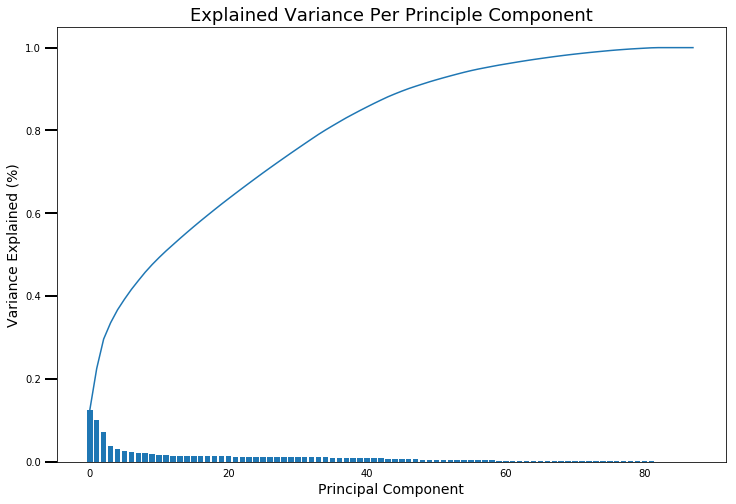

In [73]:
scree_plot(pca, figsize=(12, 8))

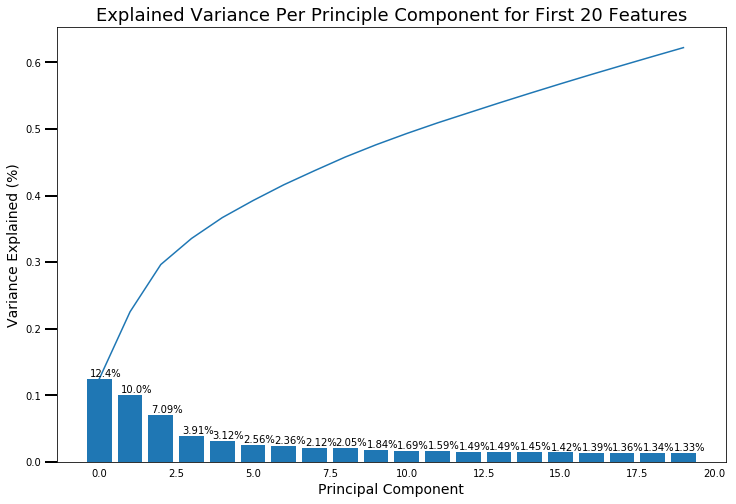

In [74]:
scree_plot(pca, annotate=True, limit=20, figsize=(12, 8))

In [75]:
for i in np.arange(5, 40, 5):
    print('For {} components, explained variance:'.format(i), 
          pca.explained_variance_ratio_[:i].sum())

For 5 components, explained variance: 0.366851638617
For 10 components, explained variance: 0.47627816376
For 15 components, explained variance: 0.553589032089
For 20 components, explained variance: 0.622232052868
For 25 components, explained variance: 0.685501558102
For 30 components, explained variance: 0.745177498171
For 35 components, explained variance: 0.801159689246


In [114]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_20 = PCA(n_components=20)
X_pca_20 = pca_20.fit_transform(azdias_standard)

### Discussion 2.2: Perform Dimensionality Reduction

I decided to retain 30 principal components, as it expalains more than 88% variances while reducing the number of features by more than 50%.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [116]:
def pca_results(full_dataset, pca):
    # Create dimensions index
    dimensions = ['Dimension {}'.format(i) for i \
                  in range(1, len(pca.components_) + 1)]
    
    # Capture pca components
    pca_comp = pca.components_
    
    # Create components df
    components_df = pd.DataFrame(np.round(pca_comp, 4), 
                              columns= full_dataset.columns)
    components_df.index = dimensions
    
    # Create PCA variance explained df
    ratios = pca.explained_variance_ratio_.reshape(len(pca_comp), 1)
    ratios_df = pd.DataFrame(np.round(ratios, 4), 
                             columns=['Explained Variance'])
    ratios_df.index = dimensions
    
    # Return combined df
    return pd.merge(ratios_df, components_df, left_index=True, right_index=True)

In [117]:
results = pca_results(azdias_consistent_code, pca_20)
results.head()

,Explained Variance,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,...,GFK_URLAUBERTYP_10,GFK_URLAUBERTYP_11,GFK_URLAUBERTYP_12,NATIONALITAET_KZ_1,NATIONALITAET_KZ_2,NATIONALITAET_KZ_3,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
Dimension 1,0.1287,-0.1574,-0.0072,0.2192,-0.1737,0.1447,-0.0952,-0.1048,-0.1325,-0.1093,...,-0.0058,0.0331,0.0752,-0.0855,0.0710,0.0431,0.1372,0.1093,0.1851,-0.1214
Dimension 2,0.1023,0.2270,0.0735,-0.0281,0.2015,-0.1994,0.1885,0.2033,-0.1371,-0.0354,...,0.0062,-0.0072,-0.0271,0.0580,-0.0379,-0.0437,-0.2250,0.0354,0.1024,-0.0236
Dimension 3,0.0688,0.0653,-0.3694,-0.1505,0.0859,-0.0832,0.1757,0.0766,0.0532,0.0527,...,0.0025,-0.0081,-0.0213,0.0086,0.0199,-0.0424,-0.0920,-0.0527,0.0196,-0.0083
Dimension 4,0.0424,-0.0269,0.0382,-0.0590,0.0067,0.0077,0.1145,-0.0677,0.0968,0.3472,...,0.0423,-0.0134,-0.1034,-0.0069,0.0103,-0.0030,0.0354,-0.3472,-0.1091,0.0592
Dimension 5,0.0306,0.0572,-0.0122,-0.0328,0.0123,-0.0029,-0.0719,0.0918,0.0132,-0.0987,...,-0.0069,0.0244,-0.0767,-0.0068,0.0159,-0.0110,0.0053,0.0987,0.0866,-0.0341


In [118]:
def plot_pca_dim(results_df, pca, dimension_name, figsize=(14, 8)):
    # Collect dimension info
    dimension = results_df.loc[dimension_name, 'ALTERSKATEGORIE_GROB':]\
    .sort_values(ascending=False)
    positive = dimension[dimension >=0]
    negative = dimension[dimension <0]
    
    # Create bar plot
    plt.figure(figsize=figsize)
    plt.subplot(211)
    positive.plot(kind='bar')
    plt.axhline(y=0.15, ls='--', c='#b3b3b3', lw=1)
    #plt.grid(axis='y')
    plt.ylabel("Feature Weights")
    plt.subplot(212)
    negative.plot(kind='bar')
    plt.axhline(y=-0.15, ls='--', c='#b3b3b3', lw=1);
    #plt.grid(axis='y')
    plt.ylabel("Feature Weights")
    plt.subplots_adjust(bottom=0.8)
    plt.suptitle("{}: {}% Variance Explained".format(
        dimension_name, 
        np.round(results_df.loc[dimension_name, 'Explained Variance']*100, 2)),
                 fontsize=18)
    plt.tight_layout()

In [119]:
def weighted_features(results, dimension_name):
    print("High Positive\n", 
      results.loc[dimension_name][results.loc[dimension_name] >= 0.15].sort_values(ascending=False))
    print("\nHigh Negative\n", 
      results.loc[dimension_name][results.loc[dimension_name] <= -0.15].sort_values())

In [120]:
weighted_features(results, 'Dimension 1')


High Positive
 MOBI_REGIO           0.2196
FINANZ_MINIMALIST    0.2192
PLZ8_ANTG3           0.2001
PLZ8_ANTG4           0.1940
WEALTH               0.1851
ORTSGR_KLS9          0.1743
EWDICHTE             0.1712
Name: Dimension 1, dtype: float64

High Negative
 KBA05_ANTG1            -0.2055
PLZ8_ANTG1             -0.2010
KBA05_GBZ              -0.1951
HH_EINKOMMEN_SCORE     -0.1869
FINANZ_SPARER          -0.1737
ALTERSKATEGORIE_GROB   -0.1574
PLZ8_GBZ               -0.1506
Name: Dimension 1, dtype: float64


In [121]:
weighted_features(results, 'Dimension 2')

High Positive
 SEMIO_REL                0.2281
ALTERSKATEGORIE_GROB     0.2270
SEMIO_PFLICHT            0.2091
FINANZ_UNAUFFAELLIGER    0.2033
SEMIO_TRADV              0.2023
FINANZ_SPARER            0.2015
SEMIO_KULT               0.1886
FINANZ_ANLEGER           0.1885
SEMIO_RAT                0.1525
Name: Dimension 2, dtype: float64

High Negative
 DECADE              -0.2250
SEMIO_ERL           -0.2004
FINANZ_VORSORGER    -0.1994
ONLINE_AFFINITAET   -0.1718
SEMIO_LUST          -0.1569
RETOURTYP_BK_S      -0.1566
Name: Dimension 2, dtype: float64


In [122]:
weighted_features(results, 'Dimension 3')

High Positive
 SEMIO_KAEM        0.3400
SEMIO_DOM         0.3126
SEMIO_KRIT        0.2727
SEMIO_RAT         0.2057
SEMIO_ERL         0.1830
FINANZ_ANLEGER    0.1757
Name: Dimension 3, dtype: float64

High Negative
 ANREDE_KZ           -0.3694
SEMIO_VERT          -0.3485
SEMIO_SOZ           -0.2673
SEMIO_FAM           -0.2601
SEMIO_KULT          -0.2426
FINANZ_MINIMALIST   -0.1505
Name: Dimension 3, dtype: float64


### Discussion 2.3: Interpret Principal Components

#### In first principal component:
FINANZ_MINIMALIST (Low financial interest) and MOBI_REGIO (Movement patterns) have a positive correlationc, that mean this attribute tend to increase together.
#### In second principal component:
SEMIO_REL (Personality typology ), ALTERSKATEGORIE_GROB (Estimated age based on given name analysis) and  SEMIO_PFLICHT (Personality typology) have a positive correlation , that mean this attribute tend to increase together. 
#### In third principal component :
SEMIO_KAEM (Personality typology), SEMIO_DOM (Personality typology) and SEMIO_KRIT (Personality typology) have a positive correlation , that mean this attribute tend to increase together. 


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [123]:
from sklearn.cluster import KMeans

In [ ]:
kmeans_10 = KMeans(n_clusters=10).fit(X_pca_20)

In [88]:
kmeans_10.score(X_pca_20)

-19662344.697624624

In [92]:
k_means = range(1, 5)
low_scores = []

for k in k_means:
    print('Starting k = {} fitting'.format(k))
    model = KMeans(k).fit(X_pca_20)
    score = model.score(X_pca_20)
    low_scores.append(-score)

Starting k = 1 fitting
Starting k = 2 fitting
Starting k = 3 fitting
Starting k = 4 fitting


In [91]:
k_means = range(5, 31)
scores = []

for k in k_means:
    print('Starting k = {} fitting'.format(k))
    model = KMeans(k).fit(X_pca_20)
    score = model.score(X_pca_20)
    scores.append(-score)

Starting k = 5 fitting
Starting k = 6 fitting
Starting k = 7 fitting
Starting k = 8 fitting
Starting k = 9 fitting
Starting k = 10 fitting
Starting k = 11 fitting
Starting k = 12 fitting
Starting k = 13 fitting
Starting k = 14 fitting
Starting k = 15 fitting
Starting k = 16 fitting
Starting k = 17 fitting
Starting k = 18 fitting
Starting k = 19 fitting
Starting k = 20 fitting
Starting k = 21 fitting
Starting k = 22 fitting
Starting k = 23 fitting
Starting k = 24 fitting
Starting k = 25 fitting
Starting k = 26 fitting
Starting k = 27 fitting
Starting k = 28 fitting
Starting k = 29 fitting
Starting k = 30 fitting


In [93]:
total_scores = low_scores + scores

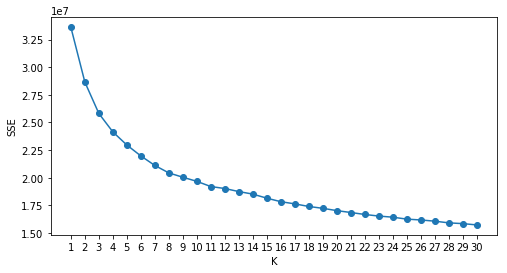

In [94]:
# Plot elbow plot
x = range(1, 31)
plt.figure(figsize=(8, 4))
plt.plot(x, total_scores, marker='o')
plt.xticks(x)
plt.xlabel('K')
plt.ylabel('SSE');

In [124]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans_9 = KMeans(n_clusters=9).fit(X_pca_20)

### Discussion 3.1: Apply Clustering to General Population

The curve for the clustering didn't have a sharp obvious change. I decided to use 9 clusters.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [125]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
customers.shape

(191652, 85)

In [126]:
customers_clean = customers.copy()
customers_clean = clean_data(customers_clean)

In [127]:
customers_clean.shape

(115643, 92)

In [128]:

# Impute means
customers_imputed = imputer.transform(customers_clean)
# Standardize
customers_standard = scaler.transform(customers_imputed)
# Clustered 
customers_pca = pca_20.transform(customers_standard)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [130]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
azdias_predict = pd.DataFrame(np.array(kmeans_9.predict(X_pca_20)), columns=['Predictions'])
customer_predict = pd.DataFrame(np.array(kmeans_9.predict(customers_pca)), columns=['Predictions'])


In [131]:
azdias_prop = azdias_predict.groupby('Predictions').size()
customer_prop = customer_predict.groupby('Predictions').size()
print(azdias_prop)
print(customer_prop)

Predictions
0    53009
1    71572
2    63860
3    87970
4    84954
5    71027
6    72264
7    60396
8    58157
dtype: int64
Predictions
0     4611
1    17945
2     2702
3    12257
4    17640
5    46601
6     6398
7     4036
8     3453
dtype: int64


In [132]:
azdias_miss_prop = pd.Series(azdias.shape[0] - azdias_consistent_code.shape[0])
customer_miss_prop = pd.Series(customers.shape[0] - customers_clean.shape[0])
# Append on to arrays
azdias_prop = azdias_prop.append(azdias_miss_prop)
customer_prop = customer_prop.append(customer_miss_prop)
print(azdias_prop)
print(customer_prop)

0     53009
1     71572
2     63860
3     87970
4     84954
5     71027
6     72264
7     60396
8     58157
0    268012
dtype: int64
0     4611
1    17945
2     2702
3    12257
4    17640
5    46601
6     6398
7     4036
8     3453
0    76009
dtype: int64


In [134]:
azdias_prop.index = range(10)
customer_prop.index = range(10)

In [135]:

azdias_prop = (azdias_prop/azdias_prop.sum()).reset_index()
customer_prop = (customer_prop/customer_prop.sum()).reset_index()

In [136]:
azdias_prop['source'] = 'population'
azdias_prop.columns = ['label', 'proportion', 'source']
customer_prop['source'] = 'customers'
customer_prop.columns = ['label', 'proportion', 'source']

In [137]:

predictions = pd.concat([azdias_prop, customer_prop])
#predictions.columns = ['population', 'customer']
predictions.head()

,label,proportion,source
0,0,0.059479,population
1,1,0.080308,population
2,2,0.071655,population
3,3,0.098707,population
4,4,0.095323,population


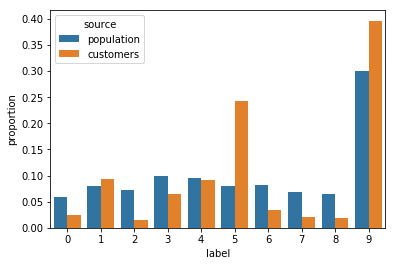

In [138]:

sns.barplot(x='label', y='proportion', hue='source', data=predictions);


In [139]:
customer_labels = pd.merge(left=pd.DataFrame(customers_pca), right=customer_predict, left_index=True, right_index=True)
customer_labels.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,Predictions
0,-3.538992,0.177370,3.346199,-2.147275,-2.904336,2.925540,0.222236,3.719613,-2.269834,2.691579,...,-1.465718,-1.155285,2.317558,-0.704918,-1.411667,-1.011776,0.891057,-2.140543,0.426612,5
1,-1.011150,3.982883,-1.644903,-0.327066,0.397504,-0.239187,-0.634142,4.890226,-1.223080,1.836902,...,-2.702019,-1.983924,0.334652,-0.889483,-1.069073,2.256764,2.235054,-1.173033,-1.805846,3
2,1.863056,-2.105909,0.274167,-0.271885,2.004155,2.254179,-1.967998,6.501823,-2.266920,3.908120,...,-2.192294,-2.922153,2.247874,0.237351,-2.557863,3.648447,1.608107,-2.799942,-1.051032,8
3,-0.996692,0.709284,2.207195,-0.358077,-2.185012,2.386604,-1.169352,4.118677,-0.725233,2.713782,...,0.922478,-2.018469,0.197240,0.744991,-0.923712,2.282242,-0.155825,-0.950519,-0.912747,5
4,-3.705000,-0.376782,2.051861,-1.943890,-1.755353,2.454596,0.008873,4.242941,-1.868301,1.383061,...,-1.371071,-1.422735,1.302817,0.828160,-1.318123,-0.198524,0.958237,-2.057056,0.108771,5


In [140]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
over_transform = pca_20.inverse_transform(customer_labels.query('Predictions == 1').drop('Predictions', axis=1))
over_regular = scaler.inverse_transform(over_transform)
over_df = pd.DataFrame(over_regular, columns=customers_clean.columns)

In [141]:
over_df.mean()[:35]

ALTERSKATEGORIE_GROB     3.678005
ANREDE_KZ                1.989656
FINANZ_MINIMALIST        1.922803
FINANZ_SPARER            3.171293
FINANZ_VORSORGER         0.675559
FINANZ_ANLEGER           1.899150
FINANZ_UNAUFFAELLIGER    3.275556
FINANZ_HAUSBAUER         0.671687
GREEN_AVANTGARDE         0.324714
HEALTH_TYP               1.631551
RETOURTYP_BK_S           1.918177
SEMIO_SOZ                4.338010
SEMIO_FAM                5.255354
SEMIO_REL                5.235224
SEMIO_MAT                5.591475
SEMIO_VERT               4.331815
SEMIO_LUST               0.791744
SEMIO_ERL                0.477928
SEMIO_KULT               5.405365
SEMIO_RAT                4.197456
SEMIO_KRIT               1.139262
SEMIO_DOM                1.937348
SEMIO_KAEM               1.776363
SEMIO_PFLICHT            4.713596
SEMIO_TRADV              4.892979
SOHO_KZ                 -0.019690
VERS_TYP                 1.606439
ANZ_PERSONEN             1.796526
ANZ_TITEL               -0.023569
HH_EINKOMMEN_S

In [144]:
over_df.mean()[35:]


MIN_GEBAEUDEJAHR      1993.420432
OST_WEST_KZ              0.474014
WOHNLAGE                 4.946056
KBA05_ANTG1              1.898599
KBA05_ANTG2              0.950090
KBA05_ANTG3              0.737249
KBA05_ANTG4              0.128822
KBA05_GBZ                3.537023
BALLRAUM                 5.256931
EWDICHTE                 2.333705
INNENSTADT               5.976076
GEBAEUDETYP_RASTER       4.369561
KKK                      0.804270
MOBI_REGIO               2.471007
ONLINE_AFFINITAET        2.132970
REGIOTYP                 2.031487
KBA13_ANZAHL_PKW       766.797084
PLZ8_ANTG1               2.953387
PLZ8_ANTG2               1.950992
PLZ8_ANTG3               0.888862
PLZ8_ANTG4               0.270147
PLZ8_HHZ                 3.597262
PLZ8_GBZ                 3.968490
ARBEIT                   2.792977
ORTSGR_KLS9              3.483391
RELAT_AB                 1.821859
CJT_GESAMTTYP_1          1.000000
CJT_GESAMTTYP_2          0.371967
CJT_GESAMTTYP_3          0.507192
CJT_GESAMTTYP_

In [145]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
under_transform = pca_20.inverse_transform(customer_labels.query('Predictions == 0').drop('Predictions', axis=1))
under_regular = scaler.inverse_transform(under_transform)
under_df = pd.DataFrame(under_regular, columns=customers_clean.columns)

In [146]:
under_df.mean()[:35]

ALTERSKATEGORIE_GROB     2.087051
ANREDE_KZ                1.222159
FINANZ_MINIMALIST        2.531341
FINANZ_SPARER            1.308411
FINANZ_VORSORGER         2.161108
FINANZ_ANLEGER           0.706926
FINANZ_UNAUFFAELLIGER    1.767611
FINANZ_HAUSBAUER         0.406572
GREEN_AVANTGARDE         0.727715
HEALTH_TYP               1.768612
RETOURTYP_BK_S           3.266111
SEMIO_SOZ                1.016025
SEMIO_FAM                1.887498
SEMIO_REL                1.947457
SEMIO_MAT                4.943597
SEMIO_VERT               1.787025
SEMIO_LUST               2.596926
SEMIO_ERL                4.385078
SEMIO_KULT               1.784451
SEMIO_RAT                4.027965
SEMIO_KRIT               4.000537
SEMIO_DOM                4.703714
SEMIO_KAEM               5.098633
SEMIO_PFLICHT            2.627027
SEMIO_TRADV              3.182739
SOHO_KZ                 -0.032400
VERS_TYP                 1.970667
ANZ_PERSONEN             2.462859
ANZ_TITEL               -0.038680
HH_EINKOMMEN_S

In [147]:
under_df.mean()[35:]

MIN_GEBAEUDEJAHR      1993.644095
OST_WEST_KZ              0.223957
WOHNLAGE                 4.587719
KBA05_ANTG1              1.830873
KBA05_ANTG2              0.705461
KBA05_ANTG3              1.066403
KBA05_ANTG4              0.098410
KBA05_GBZ                3.424702
BALLRAUM                 5.283820
EWDICHTE                 2.265174
INNENSTADT               5.961612
GEBAEUDETYP_RASTER       4.459796
KKK                      0.928944
MOBI_REGIO               2.525440
ONLINE_AFFINITAET        2.917952
REGIOTYP                 2.382363
KBA13_ANZAHL_PKW       799.973481
PLZ8_ANTG1               2.932841
PLZ8_ANTG2               1.760839
PLZ8_ANTG3               0.986736
PLZ8_ANTG4               0.378349
PLZ8_HHZ                 3.747606
PLZ8_GBZ                 3.978749
ARBEIT                   2.862239
ORTSGR_KLS9              3.695977
RELAT_AB                 1.417764
CJT_GESAMTTYP_1          1.000000
CJT_GESAMTTYP_2          0.154328
CJT_GESAMTTYP_3          0.627556
CJT_GESAMTTYP_

### Discussion 3.3: Compare Customer Data to Demographics Data

1, 5 and 9 clusters are overrepresented in the customer data compared to the population data. 2, 3, 4, 6, 7 and 8 clusters are underrepresented in the customer data compared to the population data:

The kind of people are part of a cluster that is overrepresented: 
- FINANZ_MINIMALIST (Financial typology) 
- MOBI_REGIO (Movement patterns)
- ORTSGR_KLS9 ( Size of community)
- EWDICHTE (Density of households per square kilometer)
These like the second dimension.

The kind of people are part of a cluster that is underrepresented : 
- SEMIO_REL(Personality typology)
- ALTERSKATEGORIE_GROB(Estimated age based on given name analysis)
- SEMIO_PFLICHT (Personality typology)
- FINANZ_UNAUFFAELLIGER (Financial typology)
- SEMIO_TRADV  (Personality typology)
- FINANZ_SPARER (Financial typology)
- SEMIO_KULT (Personality typology)
- SEMIO_RAT (Personality typology)
These like the second dimension.


> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.